# 06 - Noise

## Some mandatory imports and Helpers

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, execute
from qiskit import IBMQ, Aer, transpile
from qiskit.providers.aer import AerSimulator
from qiskit.quantum_info.operators import Pauli
from qiskit.circuit.library import RXGate
import qiskit_aer.noise as noise
from qiskit.tools.visualization import plot_histogram
import numpy as np
import matplotlib.pyplot as plt

import pickle # not needed if IBMQ account is being used

### Build circuit

We use this method to dynamically build the $X^{\otimes d}$ circuit from the lecture.

In [2]:
def build_circuit(n_x_gates:int) -> QuantumCircuit:
    qc = QuantumCircuit(1)

    for i in range(n_x_gates):
        qc.x(0)

    qc.measure_all()
    
    return qc

## Running with artificial noise properties

In the fist experiment, we will try to reproduce the plots from the lecture by creating artificial noise and apply it on the circuits above.

### Defining the noise models

Below are the definitions for coherent and incoherent noise effects.

In [3]:
def get_coherence_noise_model(noise_model:noise.NoiseModel, phi_error:float=0.1):

    rotational_error = noise.coherent_unitary_error([[  np.cos(phi_error/2),    -np.sin(phi_error/2)*1.j   ],
                                                     [  -np.sin(phi_error/2)*1.j,   np.cos(phi_error/2)    ]])

    noise_model.add_all_qubit_quantum_error(rotational_error, ["x"])
    
    basis_gates = noise_model.basis_gates
    #print(noise_model)

    return noise_model

def get_incoherence_noise_model(noise_model:noise.NoiseModel, p_error:float=0.01):

    bitflip_error = noise.pauli_error([('X',p_error), ('I', 1 - p_error)])

    noise_model.add_all_qubit_quantum_error(bitflip_error, ["x"])
    
    basis_gates = noise_model.basis_gates
    #print(noise_model)

    return noise_model

### Initialize noise model

Now, create a noise model and load the different types of noise on it.
Feel free to play around with the values and comment out a certain type of noise.

In [4]:
noise_model = noise.NoiseModel()

noise_model = get_coherence_noise_model(noise_model, 0.1)
noise_model = get_incoherence_noise_model(noise_model, 0.01)

### Run experiment

Now that we have the circuits and the noise model ready, let's create a loop where we can iteratively increase the circuit depth and simulate noise effects. Just as in the lecture, the grey hull represents the *ideal* scenario where no noise and sampling effects apply.

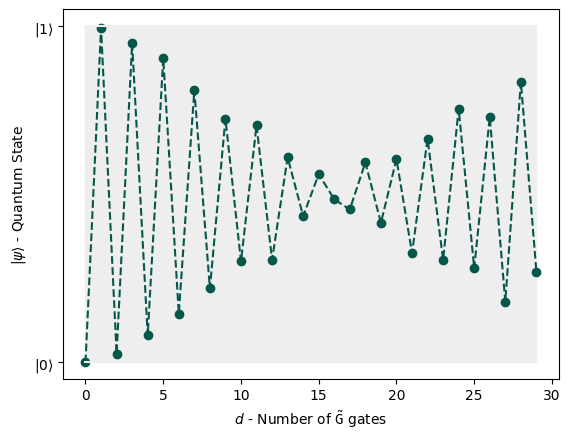

In [5]:
shots = 200
d_max = 30

exp_vals = []
for i in range(d_max):
    qc = build_circuit(i)

    backend = AerSimulator(noise_model=noise_model)

    result = backend.run(qc, shots=shots).result().get_counts(0)

    if '1' not in result:
        result['1'] = 0
    if '0' not in result:
        result['0'] = 0
        
    exp_vals.append((1 - result['0']/shots + result['1']/shots)/2)

fig, ax = plt.subplots(1,1)
ax.plot(exp_vals, '--o', color='#06574b')
ax.set_yticks([0, 1])
ax.set_yticklabels(["$\\vert 0\\rangle$", "$\\vert 1\\rangle$"])
ax.set_ylabel("$\\vert \\psi \\rangle$ - Quantum State")
ax.set_xlabel("$d$ - Number of $\\mathtt{\\tilde{G}}$ gates")
exp_1 = [1 for i in range(d_max)]
exp_0 = [0 for i in range(d_max)]
ax.plot(exp_1, color='#EEEEEE')
ax.plot(exp_0, color='#EEEEEE')
ax.fill_between([i for i in range(d_max)], exp_1, exp_0, color='#EEEEEE')
plt.show()

## Running with properties of a real quantum device

After playing around with the artificial noise, let's see how the same setup behaves with a noise model from a real quantum device.

### Get properties from real backend

To load a noise model, you can either use the provided noise model from the lecture, or create an IBMQ account and dynamically load a noise model of any device available by uncommenting the first part in the following code.

If you do so, make sure to first execute

```python
IBMQ.save_account(API_TOKEN)
```

using the token provided on the [IBM Quantum](https://quantum-computing.ibm.com/) website after registration.

In [6]:
# provider = IBMQ.load_account()
# backend = provider.get_backend('ibmq_quito')

# noise_model = noise.NoiseModel.from_backend(backend)

# with open("noise_model_ibmq_quito.pickle", mode="wb") as f:
#     pickle.dump(noise_model, f)

with open("noise_model_ibmq_quito.pickle", mode="rb") as f:
    noise_model = pickle.load(f)

print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['id', 'x', 'reset', 'cx', 'sx', 'measure']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('cx', (3, 4)), ('cx', (4, 3)), ('cx', (1, 3)), ('cx', (3, 1)), ('cx', (2, 1)), ('cx', (1, 2)), ('cx', (0, 1)), ('cx', (1, 0)), ('reset', (0,)), ('reset', (1,)), ('reset', (2,)), ('reset', (3,)), ('reset', (4,)), ('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('measure', (4,))]


## Run experiment

That's all! Now we can run the experiment from above again and check how noisy a real quantum device actually is.

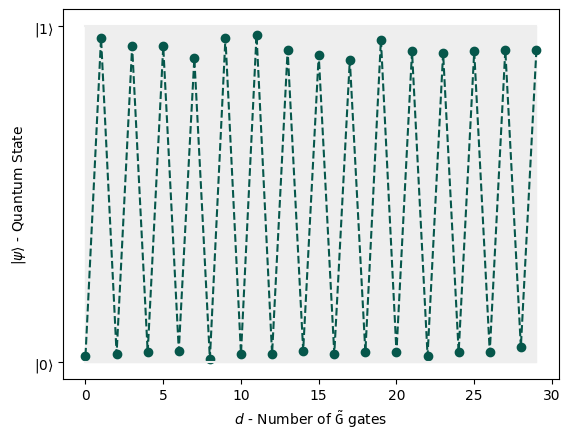

In [7]:
shots = 200
d_max = 30

exp_vals = []
for i in range(d_max):
    qc = build_circuit(i)

    backend = AerSimulator(noise_model=noise_model)

    result = backend.run(qc, shots=shots).result().get_counts(0)

    if '1' not in result:
        result['1'] = 0
    if '0' not in result:
        result['0'] = 0
        
    exp_vals.append((1 - result['0']/shots + result['1']/shots)/2)

fig, ax = plt.subplots(1,1)
ax.plot(exp_vals, '--o', color='#06574b')
ax.set_yticks([0, 1])
ax.set_yticklabels(["$\\vert 0\\rangle$", "$\\vert 1\\rangle$"])
ax.set_ylabel("$\\vert \\psi \\rangle$ - Quantum State")
ax.set_xlabel("$d$ - Number of $\\mathtt{\\tilde{G}}$ gates")
exp_1 = [1 for i in range(d_max)]
exp_0 = [0 for i in range(d_max)]
ax.plot(exp_1, color='#EEEEEE')
ax.plot(exp_0, color='#EEEEEE')
ax.fill_between([i for i in range(d_max)], exp_1, exp_0, color='#EEEEEE')
plt.show()

As you can see, e.g. the gate error effects are barely visible. However, you might note that there is a small shift towards the $\vert 0 \rangle$ state. If you increase the circuit depth to e.g. $300$ you will also notice the effect of incoherent noise.
Such a circuit depth might seem ridiculously large, but keep in mind that transpilation process **will** increase the overall gate count significantly due to:
- the necessity of interaction between qubits which aren't connected according to the device topology
- the requirement to achieve very precise rotations with gates not in the set available on the real hardware

We are omitting the transpiler here it would optimize our circuit to either one or zero $X$ gates.

## Measurement Error Mitigation

Let's see if we can mitigate the measurement error we observed in the previous example.
Therefore we will apply a very simple but yet effective mitigation technique where we evaluate the shift caused by the measurement error and store the deviation in a calibration matrix.
The inverse of the latter will then be multiplied with the circuits outcome to retrieve the mitigated result.

In [8]:
n_qubits = 1
mat = []

for i in range(2**n_qubits):
    _qc = QuantumCircuit(n_qubits)
    idx = format(i, f'0{n_qubits}b')[::-1]
    for q, j in enumerate(idx):
        if j == '1':
            _qc.x(q)

    _qc.measure_all()

    result = backend.run(_qc, shots=shots).result().get_counts(0)
    
    mat.append([])
    for j in range(2**n_qubits):
        idx = format(j, f'0{n_qubits}b')
        if idx not in sorted(result.keys()):
            mat[i].append(0)
        else:
            mat[i].append(result[idx])

mat = np.array(mat) / shots
print(f"Calibration matrix: {mat}")

c_mat = np.linalg.inv(mat)


Calibration matrix: [[0.985 0.015]
 [0.04  0.96 ]]


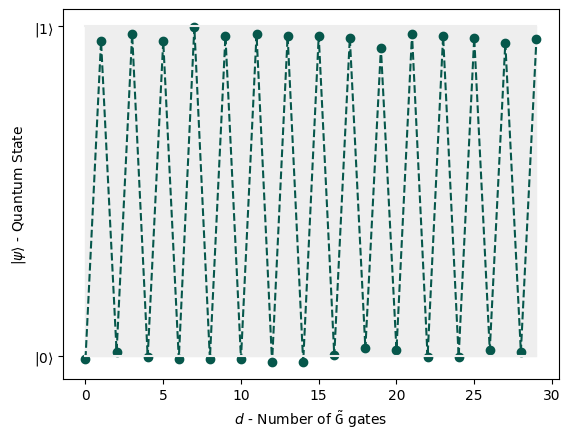

In [9]:
shots = 200
d_max = 30

exp_vals = []
for i in range(d_max):
    qc = build_circuit(i)

    backend = AerSimulator(noise_model=noise_model)

    result = backend.run(qc, shots=shots).result().get_counts(0)

    vect = []
    for i in range(2**n_qubits):
        idx = format(i, f'0{n_qubits}b')[::-1]
        if idx not in sorted(result.keys()):
            vect.append(0)
        else:
            vect.append(result[idx])
    vect = np.array(vect)

    vect_mitig = np.dot(c_mat, vect)
        
    exp_vals.append((1 - vect_mitig[0]/shots + sum(vect_mitig[1:])/shots)/len(vect))

fig, ax = plt.subplots(1,1)
ax.plot(exp_vals, '--o', color='#06574b')
ax.set_yticks([0, 1])
ax.set_yticklabels(["$\\vert 0\\rangle$", "$\\vert 1\\rangle$"])
ax.set_ylabel("$\\vert \\psi \\rangle$ - Quantum State")
ax.set_xlabel("$d$ - Number of $\\mathtt{\\tilde{G}}$ gates")
exp_1 = [1 for i in range(d_max)]
exp_0 = [0 for i in range(d_max)]
ax.plot(exp_1, color='#EEEEEE')
ax.plot(exp_0, color='#EEEEEE')
ax.fill_between([i for i in range(d_max)], exp_1, exp_0, color='#EEEEEE')
plt.show()

We can see that the result now slightly better matches the expected result by comparing it with the grey hull.

## Recap: Problem of amplitude encoding

Are those "deep" circuits then practically relevant? See yourself and play around with the number of qubits and the state we want to prepare.
Note that this large overhead mainly comes from the fact that the transpiler needs to find a way to represent this state with the available set of gates from the selected backend.

In [10]:
n_qubits = 2

q = QuantumRegister(n_qubits)
qc = QuantumCircuit(q)

value = np.random.random(2**n_qubits)
state = value / np.linalg.norm(value)

qc.initialize(state, [q[i] for i in range(n_qubits)])

qc.draw()

backend = AerSimulator(noise_model=noise_model)

qc_transpiled = transpile(qc, backend)

qc_transpiled.draw()

global phase: π/2
      ┌────────┐┌────┐┌────────────┐┌────┐┌───┐┌────┐┌────────────┐┌────┐»
q0_0: ┤ Rz(-π) ├┤ √X ├┤ Rz(1.0095) ├┤ √X ├┤ X ├┤ √X ├┤ Rz(2.6375) ├┤ √X ├»
      ├────────┤├────┤├────────────┤├────┤└─┬─┘└────┘└────────────┘└────┘»
q0_1: ┤ Rz(-π) ├┤ √X ├┤ Rz(2.3512) ├┤ √X ├──■────────────────────────────»
      └────────┘└────┘└────────────┘└────┘                               »
«      ┌────────┐┌───┐
«q0_0: ┤ Rz(-π) ├┤ X ├
«      └────────┘└─┬─┘
«q0_1: ────────────■──
«